In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Computing integrals with Motecarlo methods

This exercise show two approaches to compute integrals using Montecarlo algorithms.
The first is based on the **uniform sample average** of the function that you want to integrate, and the second uses **importance sampling**.



## 1 - Start by writing and plotting the function

Here we focus on the gaussian function:

\begin{equation}
f(x) = e^{-x^2}
\end{equation}

Write it in a python function..

In [2]:
def gaussian_func(x):
    return np.exp(-x**2)

.. and plot it in $[0,4]$

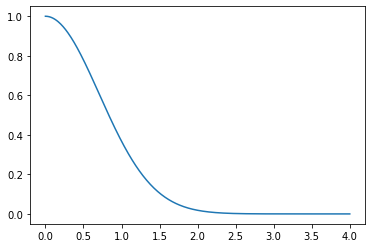

In [3]:
x = np.linspace(0,4,500)
gaussian_values = gaussian_func(x)
    
plt.plot(x, gaussian_values)
plt.show()

For the gaussian integral we know that:

\begin{equation}
 I = \int_0^\infty dx \; e^{-x^2} = \frac{\sqrt{\pi}}{2}
\end{equation}

(It's a good exercise to solve it! The trick is to consider $I^2 = \int dx dy \; exp(-x^2 - y^2)$, and to use the polar coordinates.)

However, choosing other integration boundaries, there is no a general analytical form.

## 2 - Integral with sample average

To estimate the integral we use the following property. Given $U$ a uniform random variable in $[a,b]$, $P(U = u) = 1/(b-a)$, the sample average over this uniform distribution converges to the average value of $f(x)$:

\begin{equation}
 \int_a^b dx \; f(x) = (b-a) \langle f(x) \rangle = (b-a) \lim_{N \rightarrow \infty} \frac{1}{N} \sum_{i=1}^N f(U_i)
\end{equation}

Therefore, throwing a lot of unifrom random variables $U$, try $10000$, and summing the function at that values, you can estimate the integral using the formula above.

We want to estimate the integral in $[0, \infty)$, whose value is known, $\frac{\sqrt{\pi}}{2}$.
But there is a problem: to solve such a task the uniform random variable should be generated in an infinitely long interval, and this is not computationally possible.
However, as you can see from the plot, the function approaches $0$ very quickly: the value of the integral is strongly determined by $x$ less than $3$. Larger values provide negligible contribution. This allows us to consider uniform samples in, for example, $[0,4]$. This will provide anyway a good estimate of the integral.

Write a function that takes as input the number of samples and the upper bound on the interval of the uniform samples, and return the integral estimate. Compare it with the true value.


In [4]:
def integral_sample_average(num_samples, a, b):    
    range_x = b - a
    x = np.random.rand(num_samples)*range_x + a
    integral = np.sum(gaussian_func(x))     
    integral_estimate = (b-a) * integral /num_samples
    return integral_estimate

In [5]:
integral_sample_average(20000, 0, 5)

0.8968453948813183

In [6]:
np.sqrt(np.pi)/2

0.8862269254527579

## 2 - Importance sampling

Notice that, since the sample is uniform, a lot of times I will choose values greater than $2$, which provide a very small contribution to the integral. It's like that I'm wasting a lot of sample.
The idea of importance sampling is to change the way in which my random points are sampled, by focusing more on the "more important" regions where the function to integrate is large (here, I want to sample with higher probability small $x$ values).

Let's assume that a new random variable $Y$ is a good candidate for sampling with higher frequency the important regions of my space. The probability distribution of $Y$ is given by $g(y)$.
Then the formula to estimate the integral changes in the following way:

\begin{equation}
 \int_a^b dx \; f(x) = \int_a^b dx \; \frac{f(x)}{g(x)} g(x) = \lim_{N \rightarrow \infty} \frac{1}{N} \sum_{i=1}^N \frac{f(Y_i)}{g(Y_i)}
\end{equation}

A good candidate in the case of the gaussian integral is the exponential distribution $g(y) = e^{-y}$. Indeed, it gives more weight to small values of $x$.
This is the one that we are using here, also because exponential samples are easy to generate. However this is not the only choice and there can be smarter distributions..


### 2a - Write a generator of exponentially distributed samples.

Write a function that takes as argument the number of samples and return an array of exponentially distributed samples.
Remember that, for a continuous distribution, given $U \in [0,1)$ a uniformally distributed variable, the sample of $Y$ from $g(y)$ can be obtained as follows:
\begin{equation}
Y = G^{-1}(U)
\end{equation}
where $G(y) = \int_{y_0}^y g(y') dy'$ is the cumulative distribution of $g(y)$, which has to be inverted.

For the exponential distribution, its cumulative can be analitically obtained, and its inverse can be computed. The exponential sample can be then generated by a uniform sample using:
\begin{equation}
Y = - \log(1 - U)
\end{equation}


In [24]:
def exp_distribution(y):
    return np.exp(-y)

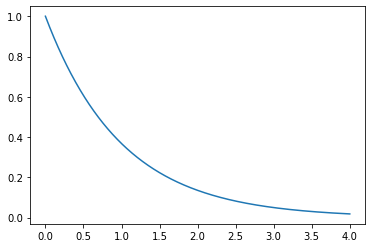

In [25]:
x = np.linspace(0,4,1000)
exp_distribution_output = exp_distribution(x)
    
plt.plot(x, exp_distribution_output)
plt.show()

In [9]:
def exp_distributed_sample(num_samples, a, b):
    range_x = b - a
    y = np.random.rand(num_samples)*range_x + a
    Y = -np.log(1-y) 
    return Y

In [11]:
exp_distributed_sample_output = exp_distributed_sample(1000, 0, 1)
# exp_distributed_sample_output

Plot the normalized histogram of $10000$ generated samples, and compare it with the exponential distribution $g(y) = e^{-y}$.

In [12]:
def normalize(output):
    mean_x = np.mean(output)
    stddev = np.std(output)
    norm_list = []
    for i in output:
        normalize = (i - mean_x)/stddev
        norm_list.append(normalize)
    return norm_list

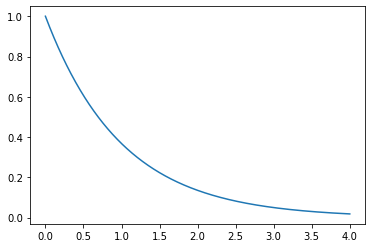

In [27]:
plt.plot(x, exp_distribution_output, label = 'exp_distribution')

No handles with labels found to put in legend.


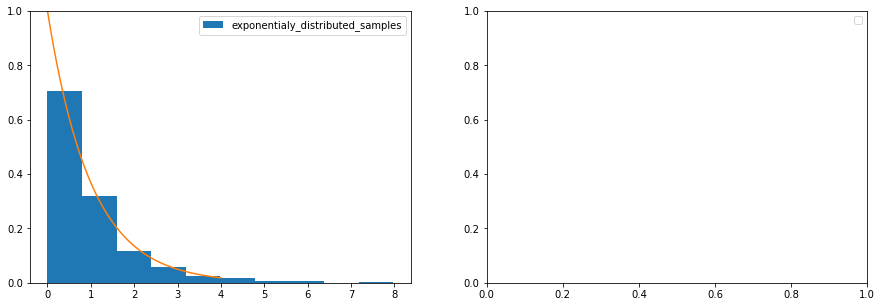

In [29]:
norm_exp_distributed_sample = normalize(exp_distributed_sample_output)
# norm_exp_distribution = normalize(exp_distribution_output)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(exp_distributed_sample_output,  density = True, label = 'exponentialy_distributed_samples')
ax[0].set_ylim(0,1)
ax[0].legend()

ax[0].plot(x, exp_distribution_output, label = 'exp_distribution')
ax[1].legend()
plt.show()

### 2b - Estimate the integral using importance sampling

Now that you have a generator of exponentially distributed samples, you can estimate the gaussian integral with importance sampling.

Write the function that, given the number of samples as input, returns the integral estimate.

In [14]:
def importance_sampling(num_samples, a, b):
    Y = exp_distributed_sample(num_samples, a, b)
    g = exp_distribution(Y)
    f = gaussian_func(Y)
    value = (1/num_samples) * np.sum(f/g)
    return value

In [15]:
importance_sampling(20000, 0, 1)

0.8859594884277118

## 3 - Comparing the performance of the two methods

Now we test if importance sampling really improve the performance.

A firts test is about the variance of the model, whose square root is the standard deviation, which gives an estimate of the error of the algorithm.

For each method (sample average and importance samping) write a function that, given the number of samples and the number of parallel realizations  as parameters, generates the average and the standard deviation of the integral estimate.

In [16]:
def compare_performance(function, num_samples, n_realizations,a, b):    
    sample_ave_list = []
    mean_list = []
    std_list = []
    for i in num_samples:
        for j in range(n_realizations):
            sample_average = function(i, a, b)
            sample_ave_list.append(sample_average)
            
        mean_sample_ave = np.mean(sample_ave_list)
        std_sample_ave = np.std(sample_ave_list)
        
        mean_list.append(mean_sample_ave)
        std_list.append(std_sample_ave)
    return mean_list, std_list

Then, using this function, store the average and the standard deviation in an array for different number of samples.

In [30]:
num_samples = [10, 100, 1000, 10000]
n_realizations = 1000
a = 0
b = 1
mean_sample_ave, std_sample_ave = compare_performance(integral_sample_average, num_samples, n_realizations,0, 10)
mean_importance_sampling, std_importance_sampling = compare_performance(importance_sampling, num_samples, n_realizations,0, 1)

Plot the average and the standard deviation of the two methods as a function of the number of samples.

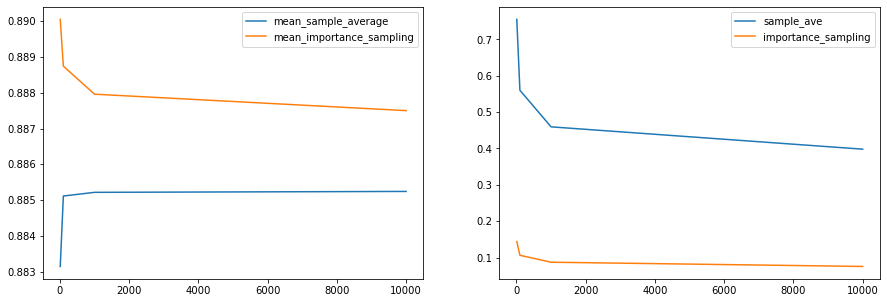

In [31]:
x = [x for x in num_samples]

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(x, mean_sample_ave, label = 'mean_sample_average')
ax[0].plot(x, mean_importance_sampling, label = 'mean_importance_sampling')
ax[0].legend()

ax[1].plot(x, std_sample_ave, label = 'sample_ave')
ax[1].plot(x, std_importance_sampling, label='importance_sampling')
ax[1].legend()
plt.show()

From the standard deviation plot you can see that, to reach the same error, the importance sampling needs one order of magnitude less samples than the uniform one!

### 3b Extra - Compare also the computational time

In [19]:
num_samples = [10, 100, 1000, 10000]
n_realizations = 1000
a = 0
b = 1

Integral sample average

In [32]:
start = time()
mean_sample_ave, std_sample_ave = compare_performance(integral_sample_average, num_samples, n_realizations,a, b)
end = time()
print(end - start)

0.4328646659851074


Importance Sampling

In [33]:
start = time()
mean_importance_sampling, std_importance_sampling = compare_performance(importance_sampling, num_samples, n_realizations,a, b)
end = time()
print(end - start)

0.756425142288208


## 4 Extra - Evaluate the gaussian integral in a generic range of values $(a,b)$ using importance sampling.

Note that, to generate samples in $(a,b)$ (let's assume that they are greater than zero) you need a proper normaliztion coefficient for the exponential distribution if $Y \in (a,b)$:

$$
g(y) = \frac{e^{-y}}{e^{-a} - e^{-b}}
$$

This changes the formula to generate exponentially distributed samples from the unifom random variable...